*Datasets used in this example are a system of hard hexagons, simulated in the NVT thermodynamic ensemble in HOOMD-Blue, for a dense fluid (phi065) and a solid (phi075)*

In [1]:
%matplotlib inline
# this is specifically for niceness in presentations;
# not recommended for real use
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from cycler import cycler
import matplotlib
from matplotlib import pyplot, cm
from matplotlib.colors import colorConverter
import time
myHexColors = ["#30A2DA", "#FC4F30", "#E5AE38", "#6D904F", "#9757DB", "#188487", "#FF7F00", "#9A2C66", "#626DDA", "#8B8B8B"]
myColorCycle = [colorConverter.to_rgb(i) for i in myHexColors]
from freud import parallel
parallel.setNumThreads(4)
from scipy.ndimage.filters import gaussian_filter

from ipywidgets import IntProgress
from IPython.display import display

# matplotlib.rcParams.update({'font.sans-serif': 'Helvetica'})
# matplotlib.rcParams.update({'font.family': 'sans-serif'})
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'axes.labelsize': 24})
matplotlib.rcParams.update({'xtick.labelsize': 18})
matplotlib.rcParams.update({'ytick.labelsize': 18})
matplotlib.rcParams.update({'savefig.pad_inches': 0.025})
matplotlib.rcParams.update({"axes.prop_cycle": cycler(color=myColorCycle)})
matplotlib.rcParams.update({"lines.linewidth": 2})

# vertices listed for plotting purposes
verts = [[0.537284965911771, 0.31020161970069976],
  [3.7988742065678664e-17, 0.6204032394013997],
  [-0.5372849659117709, 0.31020161970070004],
  [-0.5372849659117711, -0.31020161970069976],
  [-1.1396622619703597e-16, -0.6204032394013997],
  [0.5372849659117711, -0.3102016197006997]]
verts = np.array(verts)

# Potential of Mean Force and Torque (PMFT)

The PMFT returns the potential energy associated with finding a particle pair in a given configuration. The PMFT is computed in the same manner as the rdf. The basic algorithm is described below:

~~~
for each particle i:
    for each particle j:
        v_ij = position[j] - position[i]
        bin_x, bin_y = convert_to_bin(v_ij)
        pcf_array[bin_y][bin_x]++
~~~

Freud uses cell lists and parallelism to optimize this algorithm. An example for computing and viewing is shown below:

time to calc 399 frames = 9.719212055206299
speed of calc: 41.05271062444484 (frames/sec)


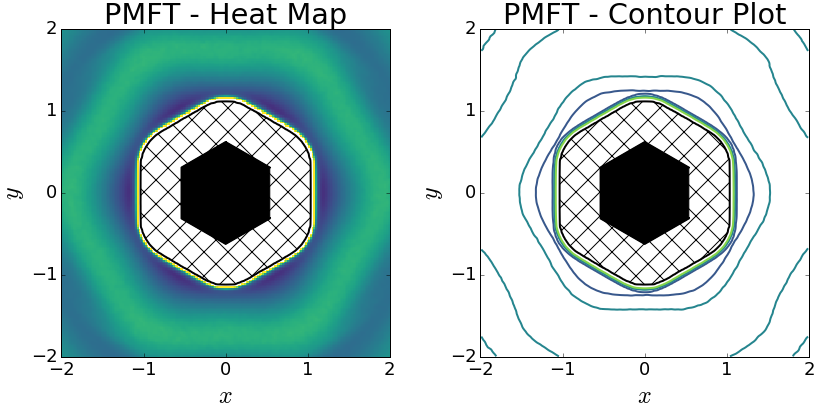

In [2]:
# import the freud object
# the rdf module is contained in the density module

from freud import box, pmft

# create the rdf object
pmft = pmft.PMFTXY2D(x_max=3.0, y_max=3.0, n_x=300, n_y=300)

# load the data
data_path = "ex_data/phi065"
box_data = np.load("{}/box_data.npy".format(data_path))
pos_data = np.load("{}/pos_data.npy".format(data_path))
quat_data = np.load("{}/quat_data.npy".format(data_path))
n_frames = pos_data.shape[0]

myProgressBar = IntProgress(min=1,max=n_frames)
display(myProgressBar)

start_time = time.time()
for i in range(1, n_frames):
    # read box, position data
    myProgressBar.value = i
    l_box = box_data[i]
    l_pos = pos_data[i]
    l_quat = quat_data[i]
    l_ang = 2*np.arctan2(np.copy(l_quat[:,3]), np.copy(l_quat[:,0]))
    l_ang = l_ang % (2.0*np.pi)
    # create the freud box object
    fbox = box.Box(Lx=l_box["Lx"], Ly=l_box["Ly"], is2D=True)
    # accumulate
    pmft.accumulate(fbox, l_pos, l_ang, l_pos, l_ang)
stop_time = time.time()
print("time to calc {} frames = {}".format(n_frames-1, stop_time-start_time))
print("speed of calc: {} (frames/sec)".format((n_frames-1)/(stop_time-start_time)))

# get the value of the histogram bins
pmft_arr = np.copy(pmft.getPMFT())
# do some simple post-processing for plotting purposes
pmft_arr[np.isinf(pmft_arr)] = np.nan
dx = (2.0 * 3.0) / pmft.getNBinsX()
dy = (2.0 * 3.0) / pmft.getNBinsY()
nan_arr = np.where(np.isnan(pmft_arr))
for i in range(pmft.getNBinsX()):
    x = -3.0 + dx * i
    for j in range(pmft.getNBinsY()):
        y = -3.0 + dy * j
        if ((x*x + y*y < 1.5) and (np.isnan(pmft_arr[j,i]))):
            pmft_arr[j, i] = 10.0
w = int(2.0 * pmft.getNBinsX() / (2.0 * 3.0))
center = int(pmft.getNBinsX()/2)
# get the center of the histogram bins
pmft_smooth = gaussian_filter(pmft_arr, 1)
pmft_image = np.copy(pmft_smooth)
pmft_image[nan_arr] = np.nan
pmft_smooth = pmft_smooth[center-w:center+w, center-w:center+w]
pmft_image = pmft_image[center-w:center+w, center-w:center+w]
x = pmft.getX()
y = pmft.getY()
reduced_x = x[center-w:center+w]
reduced_y = y[center-w:center+w]

f = pyplot.figure(figsize=(12,6))
ax0 = f.add_subplot(1, 2, 1)
ax1 = f.add_subplot(1, 2, 2)
ax0.set_title("PMFT - Heat Map")
norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=3.0)
values = [-2, -1, 0, 2]
n_values = [norm(i) for i in values]
colors = matplotlib.cm.viridis(n_values)
colors = colors[:,:3]
ax0.imshow(np.flipud(pmft_image), extent=[-2,2,-2,2], interpolation="nearest", cmap="viridis", vmin=-2.5, vmax=3.0)
ax0.contour(reduced_x, reduced_y, pmft_smooth, [9, 10], colors="black")
ax0.contourf(reduced_x, reduced_y, pmft_smooth, [9, 10], hatches="X", colors="none")
ax0.plot(verts[:,0], verts[:,1], color="black", marker=",")
ax0.fill(verts[:,0], verts[:,1], color="black")
ax0.set_aspect("equal")
ax0.xaxis.set_ticks([i for i in range(-2, 3, 1)])
ax0.yaxis.set_ticks([i for i in range(-2, 3, 1)])
ax0.set_xlabel(r"$x$")
ax0.set_ylabel(r"$y$")
# pyplot.tight_layout()
# pyplot.show()

# pyplot.figure(figsize=(8,8))
ax1.set_title("PMFT - Contour Plot")
norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=3.0)
values = [-2, -1, 0, 2]
n_values = [norm(i) for i in values]
colors = matplotlib.cm.viridis(n_values)
colors = colors[:,:3]
ax1.contour(reduced_x, reduced_y, pmft_smooth, [-2, -1, 0, 2],
    colors=colors)
ax1.contour(reduced_x, reduced_y, pmft_smooth, [9, 10], colors="black")
ax1.contourf(reduced_x, reduced_y, pmft_smooth, [9, 10], hatches="X", colors="none")
ax1.plot(verts[:,0], verts[:,1], color="black", marker=",")
ax1.fill(verts[:,0], verts[:,1], color="black")
ax1.set_aspect("equal")
ax1.xaxis.set_ticks([i for i in range(-2, 3, 1)])
ax1.yaxis.set_ticks([i for i in range(-2, 3, 1)])
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$y$")
pyplot.tight_layout()
pyplot.show()

time to calc 399 frames = 9.379848003387451
speed of calc: 42.538002732656714 (frames/sec)


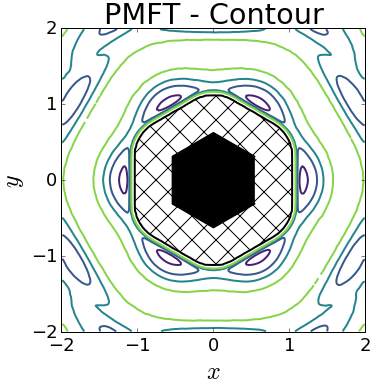

In [3]:
# import the freud object
# the rdf module is contained in the density module

from freud import box, pmft

# create the rdf object
pmft = pmft.PMFTXY2D(x_max=3.0, y_max=3.0, n_x=300, n_y=300)

# load the data
data_path = "ex_data/phi075"
box_data = np.load("{}/box_data.npy".format(data_path))
pos_data = np.load("{}/pos_data.npy".format(data_path))
quat_data = np.load("{}/quat_data.npy".format(data_path))
n_frames = pos_data.shape[0]

myProgressBar = IntProgress(min=1,max=n_frames)
display(myProgressBar)

start_time = time.time()
for i in range(1, n_frames):
    # read box, position data
    myProgressBar.value = i
    l_box = box_data[i]
    l_pos = pos_data[i]
    l_quat = quat_data[i]
    l_ang = 2*np.arctan2(np.copy(l_quat[:,3]), np.copy(l_quat[:,0]))
    l_ang = l_ang % (2.0*np.pi)
    # create the freud box object
    fbox = box.Box(Lx=l_box["Lx"], Ly=l_box["Ly"], is2D=True)
    # accumulate
    pmft.accumulate(fbox, l_pos, l_ang, l_pos, l_ang)
stop_time = time.time()
print("time to calc {} frames = {}".format(n_frames-1, stop_time-start_time))
print("speed of calc: {} (frames/sec)".format((n_frames-1)/(stop_time-start_time)))

# get the value of the histogram bins
pmft_arr = np.copy(pmft.getPMFT())
# post-processing for plotting
pmft_arr[np.isinf(pmft_arr)] = np.nan
dx = (2.0 * 3.0) / pmft.getNBinsX()
dy = (2.0 * 3.0) / pmft.getNBinsY()
for i in range(pmft.getNBinsX()):
    x = -3.0 + dx * i
    for j in range(pmft.getNBinsY()):
        y = -3.0 + dy * j
        if ((x*x + y*y < 1.5) and (np.isnan(pmft_arr[j,i]))):
            pmft_arr[j, i] = 10.0
w = int(2.0 * pmft.getNBinsX() / (2.0 * 3.0))
center = int(pmft.getNBinsX()/2)
# get the center of the histogram bins
pmft_reduced = np.array(pmft_arr[center-w:center+w, center-w:center+w])
pmft_smooth = gaussian_filter(pmft_reduced, 1)
x = pmft.getX()
y = pmft.getY()
reduced_x = x[center-w:center+w]
reduced_y = y[center-w:center+w]

pyplot.figure(figsize=(6,6))
pyplot.title("PMFT - Contour")
norm = matplotlib.colors.Normalize(vmin=-2.5,vmax=3.0)
values = [-2, -1, 0, 2]
n_values = [norm(i) for i in values]
colors = matplotlib.cm.viridis(n_values)
colors = colors[:,:3]
pyplot.contour(reduced_x, reduced_y, pmft_smooth, [-2, -1, 0, 2],
    colors=colors)
pyplot.contour(reduced_x, reduced_y, pmft_smooth, [9, 10], colors="black")
pyplot.contourf(reduced_x, reduced_y, pmft_smooth, [9, 10], hatches="X", colors="none")
pyplot.plot(verts[:,0], verts[:,1], color="black", marker=",")
pyplot.fill(verts[:,0], verts[:,1], color="black")
pyplot.axes().set_aspect("equal")
pyplot.xticks([i for i in range(-2, 3, 1)])
pyplot.yticks([i for i in range(-2, 3, 1)])
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.tight_layout()
pyplot.show()